<a href="https://colab.research.google.com/github/huyminh1115/Trip-Advisor-Hotel-Project/blob/main/Code/Final_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
    gpu_name = tf.config.list_physical_devices('GPU')[0]
    print("GPU in use:", gpu_name)
else:
    print("GPU is not available.")


GPU is available.
GPU in use: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [68]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_data.csv")

In [26]:
data.head()

,Review,Rating,words,word_count,tokenized,tokenized_words,new_rating,label
0,nice hotel expensive parking got good deal sta...,4,"['nice', 'hotel', 'expensive', 'parking', 'got...",87,nice hotel expensive parking get good deal sta...,"['nice', 'hotel', 'expensive', 'parking', 'get...",average,2
1,ok nothing special charge diamond member hilto...,2,"['ok', 'nothing', 'special', 'charge', 'diamon...",250,ok nothing special charge diamond member hilto...,"['ok', 'nothing', 'special', 'charge', 'diamon...",poor,0
2,nice rooms not 4* experience hotel monaco seat...,3,"['nice', 'rooms', 'not', '4*', 'experience', '...",217,nice room not experience hotel monaco seattle ...,"['nice', 'room', 'not', 'experience', 'hotel',...",average,1
3,"unique, great stay, wonderful time hotel monac...",5,"['unique,', 'great', 'stay,', 'wonderful', 'ti...",89,unique great stay wonderful time hotel monaco ...,"['unique', 'great', 'stay', 'wonderful', 'time...",excellent,2
4,"great stay great stay, went seahawk game aweso...",5,"['great', 'stay', 'great', 'stay,', 'went', 's...",191,great stay great stay go seahawk game awesome ...,"['great', 'stay', 'great', 'stay', 'go', 'seah...",excellent,2


count    20491.000000
mean       100.464594
std         96.061541
min          7.000000
25%         47.000000
50%         74.000000
75%        119.000000
max       1901.000000
Name: review_length, dtype: float64


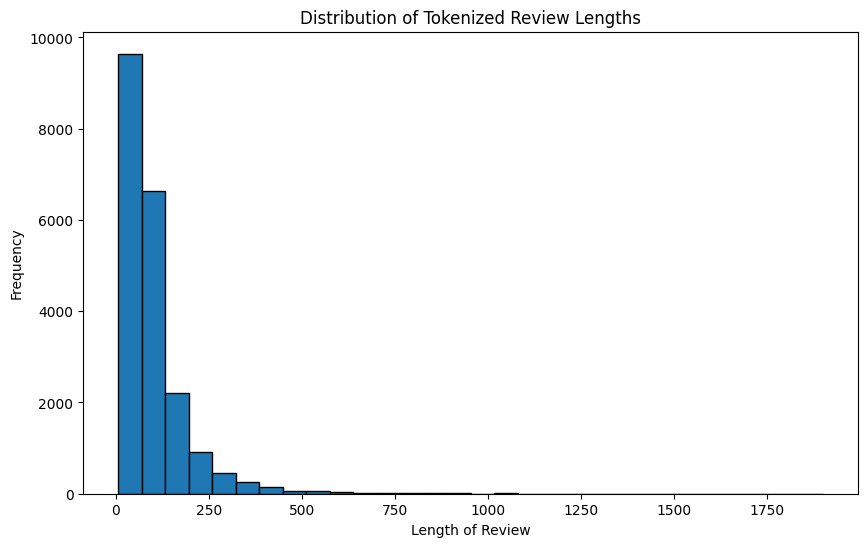

In [29]:
import ast  # Used to safely parse the string representation of lists

# Ensure the 'tokenized_review' column contains strings like "['word1', 'word2']"
data['review_length'] = data['tokenized_words'].apply(lambda x: len(ast.literal_eval(x)))

# Display basic statistics about the review lengths
stats = data['review_length'].describe()
print(stats)

# Optional: Plot a histogram to visualize the distribution of review lengths
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['review_length'], bins=30, edgecolor='black')
plt.title('Distribution of Tokenized Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()


In [30]:
all_words = data['tokenized_words'].apply(lambda x: ast.literal_eval(x))
all_words = all_words.explode().tolist()

unique_words = set(all_words)
print(f'Number of uniquie words: {len(unique_words)}')

Number of uniquie words: 43654


In [51]:
from collections import Counter
import matplotlib.pyplot as plt

word_counts = Counter(all_words)

top_1000_words = word_counts.most_common(1000)
top_1000_data = pd.DataFrame(top_1000_words, columns=['Word', 'Frequency'])
print(top_1000_data)

top_2000_words = word_counts.most_common(2000)
top_2000_data = pd.DataFrame(top_2000_words, columns=['Word', 'Frequency'])
print(top_2000_data)

M = 100
filtered_words = {word: count for word, count in word_counts.items() if count >= M}
len(filtered_words)

         Word  Frequency
0       hotel      53633
1         not      53228
2        room      47634
3        stay      28112
4        good      22152
..        ...        ...
995   nightly        316
996   complex        316
997  mosquito        316
998    nearly        315
999     spray        315

[1000 rows x 2 columns]
            Word  Frequency
0          hotel      53633
1            not      53228
2           room      47634
3           stay      28112
4           good      22152
...          ...        ...
1995    accurate        112
1996  department        112
1997        sept        112
1998  restaraunt        112
1999      candle        112

[2000 rows x 2 columns]


2152

In [52]:
X = np.array(data['tokenized_words'].tolist())
y = data['label']

In [56]:
from sklearn.model_selection import KFold

tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['tokenized'])
max_len = 120  # Maximum sequence length

# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Convert labels to categorical format
labels = to_categorical(y, num_classes=3)

# KFold setup for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [69]:
# Store results for each fold
results = []

def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=2000, output_dim=128, input_length=max_len))  # Embedding layer
    model.add(LSTM(64))  # LSTM layer
    model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Perform 10-fold cross-validation
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(padded_sequences), start=1):
    print(f"\nRunning Fold {fold_idx}...")

    # Split data into train and test sets for this fold
    X_train, X_test = padded_sequences[train_idx], padded_sequences[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Create a new instance of the LSTM model for each fold
    model = create_lstm_model()

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
    )

    # Train the model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=100,  # Maximum number of epochs
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )
    elapsed_time = time.time() - start_time

    # Evaluate on the training set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Make predictions for metrics calculation
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_test_pred = np.argmax(model.predict(X_test), axis=1)

    # Convert categorical labels back to integer form for metrics
    y_train_true = np.argmax(y_train, axis=1)
    y_test_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')
    train_precision = precision_score(y_train_true, y_train_pred, average='weighted')
    train_recall = recall_score(y_train_true, y_train_pred, average='weighted')

    test_f1 = f1_score(y_test_true, y_test_pred, average='weighted')
    test_precision = precision_score(y_test_true, y_test_pred, average='weighted')
    test_recall = recall_score(y_test_true, y_test_pred, average='weighted')

    # Store results for this fold
    results.append({
        "Fold": fold_idx,
        "Train Accuracy": train_accuracy,
        "Train F1": train_f1,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Test Accuracy": test_accuracy,
        "Test F1": test_f1,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Time": elapsed_time
    })

    # Print fold results
    print(f"Fold {fold_idx} Results:")
    print(f"  Train -> Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, "
          f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
    print(f"  Test  -> Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, "
          f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"  Time Taken: {elapsed_time:.2f} seconds\n")

# Calculate and display averaged metrics across all folds
avg_metrics = {
    metric: np.mean([result[metric] for result in results])
    for metric in ["Train Accuracy", "Train F1", "Train Precision", "Train Recall",
                   "Test Accuracy", "Test F1", "Test Precision", "Test Recall", "Time"]
}

print("\nAveraged Results Across All Folds:")
print(f"  Train -> Accuracy: {avg_metrics['Train Accuracy']:.4f}, "
      f"F1: {avg_metrics['Train F1']:.4f}, "
      f"Precision: {avg_metrics['Train Precision']:.4f}, "
      f"Recall: {avg_metrics['Train Recall']:.4f}")
print(f"  Test  -> Accuracy: {avg_metrics['Test Accuracy']:.4f}, "
      f"F1: {avg_metrics['Test F1']:.4f}, "
      f"Precision: {avg_metrics['Test Precision']:.4f}, "
      f"Recall: {avg_metrics['Test Recall']:.4f}")
print(f"  Average Time Taken per Fold: {avg_metrics['Time']:.2f} seconds")



Running Fold 1...
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 4.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1 Results:
  Train -> Accuracy: 0.7358, F1: 0.6237, Precision: 0.5413, Recall: 0.7358
  Test  -> Accuracy: 0.7439, F1: 0.6347, Precision: 0.5534, Recall: 0.7439
  Time Taken: 68.07 seconds


Running Fold 2...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 31.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2 Results:
  Train -> Accuracy: 0.7361, F1: 0.6243, Precision: 0.5419, Recall: 0.7361
  Test  -> Accuracy: 0.7404, F1: 0.6299, Precision: 0.5481, Recall: 0.7404
  Time Taken: 141.74 seconds


Running Fold 3...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 29.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 Results:
  Train -> Accuracy: 0.7367, F1: 0.6251, Precision: 0.5428, Recall: 0.7367
  Test  -> Accuracy: 0.7350, F1: 0.6227, Precision: 0.5402, Recall: 0.7350
  Time Taken: 118.31 seconds


Running Fold 4...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 17.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 4 Results:
  Train -> Accuracy: 0.7369, F1: 0.6253, Precision: 0.5430, Recall: 0.7369
  Test  -> Accuracy: 0.7335, F1: 0.6208, Precision: 0.5381, Recall: 0.7335
  Time Taken: 93.94 seconds


Running Fold 5...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 23.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 5 Results:
  Train -> Accuracy: 0.7374, F1: 0.6259, Precision: 0.5437, Recall: 0.7374
  Test  -> Accuracy: 0.7291, F1: 0.6149, Precision: 0.5316, Recall: 0.7291
  Time Taken: 104.73 seconds


Running Fold 6...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 31.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 6 Results:
  Train -> Accuracy: 0.7369, F1: 0.6253, Precision: 0.5430, Recall: 0.7369
  Test  -> Accuracy: 0.7335, F1: 0.6208, Precision: 0.5381, Recall: 0.7335
  Time Taken: 139.52 seconds


Running Fold 7...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 45.
577/577 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 7 Results:
  Train -> Accuracy: 0.7374, F1: 0.6260, Precision: 0.5438, Recall: 0.7374
  Test  -> Accuracy: 0.7286, F1: 0.6143, Precision: 0.5309, Recall: 0.7286
  Time Taken: 168.91 seconds


Running Fold 8...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 30.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 8 Results:
  Train -> Accuracy: 0.7365, F1: 0.6247, Precision: 0.5424, Recall: 0.7365
  Test  -> Accuracy: 0.7374, F1: 0.6260, Precision: 0.5438, Recall: 0.7374
  Time Taken: 126.50 seconds


Running Fold 9...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 31.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 9 Results:
  Train -> Accuracy: 0.7367, F1: 0.6250, Precision: 0.5427, Recall: 0.7367
  Test  -> Accuracy: 0.7355, F1: 0.6234, Precision: 0.5409, Recall: 0.7355
  Time Taken: 135.49 seconds


Running Fold 10...
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 40.
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 10 Results:
  Train -> Accuracy: 0.7352, F1: 0.6230, Precision: 0.5406, Recall: 0.7352
  Test  -> Accuracy: 0.7487, F1: 0.6411, Precision: 0.5605, Recall: 0.7487
  Time Taken: 155.63 seconds


Averaged Results Across All Folds:
  Train -> Accuracy: 0.7366, F1: 0.6248, Precision: 0.5425, Recall: 0.7366
  Test  -> Accuracy: 0.7366, F1: 0.6248, Precision: 0.5426, Recall: 0.7366
  Average Time Taken per Fold: 125.28 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
